In [1]:
import glob
import numpy as np
import gpflow
import pandas as pd

In [2]:
from MATSgp.lineshape_meanfuncs import *
from MATSgp.gp_models import SwitchedGPR

import matplotlib.pyplot as plt

HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
     

2021-08-05 10:48:37.295587: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read in some data

In [3]:
dat_files = glob.glob('../Examples/Multiple Temperature Oxygen A-Band/*etalon.csv')
dat_files.sort()
dat_files

['../Examples/Multiple Temperature Oxygen A-Band/13Feb18_255K_0.2%_1000Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/14Feb18_255K_0.2%_700Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/16Feb18_255K_0.2%_200Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/17Feb18_255K_0.2%_100Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/18Feb18_255K_0.2%_50Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/1Feb18_273K_0.2%_700Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/21Feb18_237.5K_0.2%_1000Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/22Feb18_237.5K_0.2%_700Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/23Feb18_237.5K_0.2%_400Torr_etalon_Seg2_etalon.csv',
 '../Examples/Multiple Temperature Oxygen A-Band/26Feb18_237.5K_0.2%_200Torr_etalon_Seg2_etalo

In [4]:
dat = [np.loadtxt(f, delimiter=',', skiprows=1, usecols=[6, 8, 10, 14]) for f in dat_files]

In [5]:
#Create information on each dataset
data_info_list = []

for i, f in enumerate(dat_files):
    start_ind = f.find('_2')
    end_ind = f.find('K_')
    nom_temp = np.floor(float(f[start_ind+1:end_ind]))
    data_info_list.append(SpectralDataInfo(fittable=True,
                                           mole_frac=0.002022,
                                           x_shift=0.0,
                                           nominal_temp=nom_temp,
                                           abun_ratio=1.0/0.995262,
                                           constraint_dict={'x_shift': (-0.1, 0.1)})
                         )
    gpflow.set_trainable(data_info_list[-1].params['x_shift'], True)


2021-08-05 10:48:38.118410: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [6]:
x = [d[:, [2, 0, 1]] for d in dat]
for d in x:
    #d[:, 0] *= (10**6) #/ 29979245800 #Load wavenumbers directly
    d[:, 1] = np.average(d[:, 1]) + 273.15
    d[:, 2] = np.average(d[:, 2]) / 760.0
    
x = [np.hstack([x[i], np.ones((x[i].shape[0], 1))*i]) for i in range(len(x))]

y = [d[:, 3] for d in dat]

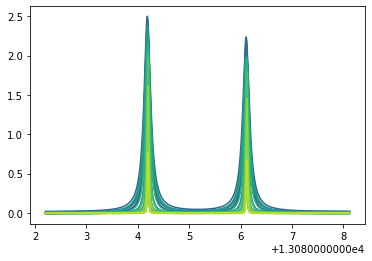

In [7]:
fig, ax = plt.subplots()
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(x)))
for i in range(len(x)):
    ax.plot(x[i][:, 0], y[i], color=colors[i])
plt.show()

# Perform some fitting

In [8]:
#Define a noise scale to make training a little more robust
noise_scale = np.average([np.std(y[i][:10]) for i in range(len(y))])
print(noise_scale)

0.0003014654543466952


In [9]:
lineparam_list = pd.read_csv('../Examples/Multiple Temperature Oxygen A-Band/Parameter_LineList.csv', index_col=0)
line_list = []
for i, line in lineparam_list.iterrows():
    line_list.append(lineshape_from_dataframe(line,
                                              limit_factor_dict={'sd_gamma':(0.01, 0.25)},
                                              line_kwargs={'dset_list':data_info_list,
                                                           'linemix':linemix_from_dataframe(line,
                                                                linemix_kwargs={'fittable':(line['sw'] >= 1.0)}),
                                                           'cutoff':50,
                                                           'noise_scale_factor':noise_scale,
                                                           'fittable':(line['sw'] >= 1.0)},
                                             )
                    )

In [10]:
for line in line_list:
    
    if isinstance(line.params['nu'], gpflow.Parameter):
        gpflow.set_trainable(line.params['nu'], True)
        gpflow.set_trainable(line.params['sw'], True)
        gpflow.set_trainable(line.params['n_gamma0'], True)
        gpflow.set_trainable(line.params['n_delta0'], True)
    
    line.params['n_gamma2'] = line.params['n_gamma0']

In [11]:
#Put it all together in the combined mean function for the model
mean_func = ComboMeanFunc(line_list)

In [12]:
#Create gpflow model
gpflow.config.set_default_jitter(1e-06)

test_x = np.vstack(x)
#Add column in y to indicate different likelihoods, i.e., different noise on different experimental datasets
test_y = np.vstack([np.vstack([y[i], np.ones_like(y[i])*i]).T for i in range(len(y))])
print(test_x.shape)
print(test_y.shape)

#Noise variance is around 1e-6 or 1e-07, which is an issue for GPflow
#To avoid numerical problems, scale output by noise standard deviation so noise variance will be order 1
test_y[:, 0] /= noise_scale

#Specify kernel that ignores the dimension specifying just the dataset index
# kern = gpflow.kernels.SquaredExponential(lengthscales=1.0*(np.amax(test_x[:, :-1], axis=0)
#                                                            - np.amin(test_x[:, :-1], axis=0)),
#                                          active_dims=[0, 1, 2])
kern = gpflow.kernels.Linear(variance=[1.0, 1.0, 1.0], active_dims=[0, 1, 2])

#Define our Gaussian process regression model
# gpr = SwitchedGPR(data=(test_x, test_y),
#                   kernel=kern,
#                   mean_function=mean_func,
#                   noise_variance=[1.0]*len(y))

#But whoah, 21860 data points? That's too many to handle for standard GPR
#Switch to sparse GPR, though don't have switched version yet...
#Can test with both standard sparse GPR, and sparse variational with switched likelihood instead
induce_pts = gpflow.inducing_variables.InducingPoints(test_x[np.random.choice(test_x.shape[0], size=100, replace=False)])
gpr = gpflow.models.SGPR(data=(test_x, test_y[:, :1]),
                         kernel=kern,
                         inducing_variable=induce_pts,
                         mean_function=mean_func,
                         noise_variance=1.0)

(21860, 4)
(21860, 2)


In [13]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SGPR.mean_function.mean_funcs[0].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[1].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[2].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[3].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[4].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[5].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[6].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[7].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[8].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[9].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[10].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[11].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[12].dset_list[0].params['mole_frac'],Parameter,Identity,,False,(),float64,0.002022
SGPR.mean_function.mean_funcs[0].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[1].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[2].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[3].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[4].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[5].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[6].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[7].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[8].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[9].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[10].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[11].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[12].dset_list[0].params['x_shift'],Parameter,SoftClip,,True,(),float64,1.3877787807814457e-17
SGPR.mean_function.mean_funcs[0].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[1].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[2].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[3].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[4].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[5].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[6].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[7].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[8].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[9].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[10].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[11].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[12].dset_list[1].params['mole_frac'],Parameter,Identity,,False,(),float64,0.002022
SGPR.mean_function.mean_funcs[0].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[1].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[2].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[3].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[4].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[5].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[6].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[7].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[8].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[9].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[10].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[11].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[12].dset_list[1].params['x_shift'],Parameter,SoftClip,,True,(),float64,1.3877787807814457e-17
SGPR.mean_function.mean_funcs[0].dset_list[2].params['mole_frac'] SGPR.mean_function.mean_funcs[1].dset_list[2].params['mole_frac'] SGPR.mean_function.mean_funcs[2].dset_list[2].params['mole_frac'] SGPR.mean_function.mean_funcs[3].dset_list[2].params['mole_frac'] SGPR.mean_function.mean_funcs[4].dset_list[2].params['mole_frac'] SGPR.mean_fun

<IPython.core.display.Javascript object>


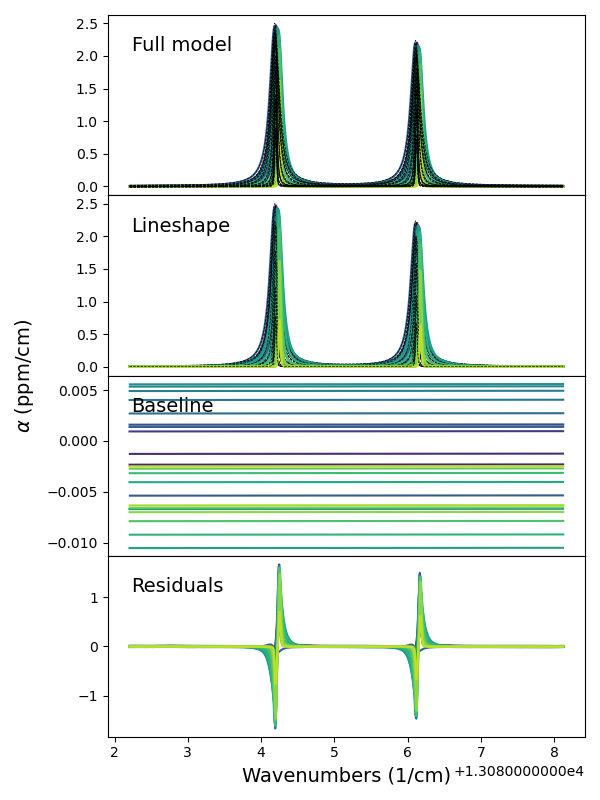

In [16]:
%matplotlib notebook

#Predictions before training
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(x)))

fig, ax = plt.subplots(4, sharex=True, sharey=False, figsize=(6, 8))

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    line = noise_scale * gpr.mean_function(x[i]).numpy().flatten()
    ax[0].errorbar(x[i][:, 0], mean, yerr=np.sqrt(var), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--', linewidth=0.5, zorder=3)
    ax[1].plot(x[i][:, 0], line, color=colors[i])
    ax[1].plot(x[i][:, 0], y[i] - (mean - line), 'k--', linewidth=0.5)
    ax[2].plot(x[i][:, 0], mean - line, color=colors[i])
    #ax[2].plot(x[i][:, 0], y[i] - line, 'k--')
    ax[3].plot(x[i][:, 0], mean - y[i], color=colors[i])

ax[1].set_ylabel(r'$\alpha$ (ppm/cm)', fontsize=14)
ax[1].yaxis.set_label_coords(-0.15, 0.0)
ax[-1].set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)
ax[0].annotate('Full model', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[1].annotate('Lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[2].annotate('Baseline', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[3].annotate('Residuals', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

In [17]:
opt = gpflow.optimizers.Scipy()

#First optimize the lineshapes without the GP model (baseline)
# gpflow.set_trainable(gpr.kernel.variance, False)
# gpflow.set_trainable(gpr.kernel.lengthscales, False)
# for l in gpr.likelihood.likelihoods:
#     gpflow.set_trainable(l.variance, False)
# opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=10))

#Or maybe try optimizing baseline first?
# for m in gpr.mean_function.mean_funcs:
#     if isinstance(m, LineShape):
#         for param in ['nu', 'sw', 'gamma0', 'sd_gamma']:
#             if isinstance(m.params[param], gpflow.Parameter):
#                 gpflow.set_trainable(m.params[param], False)
# opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=10))

#Then do all the parameters together
# gpflow.set_trainable(gpr.kernel.variance, True)
# gpflow.set_trainable(gpr.kernel.lengthscales, True)
# for l in gpr.likelihood.likelihoods:
#     gpflow.set_trainable(l.variance, True)
# for m in gpr.mean_function.mean_funcs:
#     if isinstance(m, LineShape):
#         for param in ['nu', 'sw', 'gamma0', 'sd_gamma']:
#             if isinstance(m.params[param], gpflow.Parameter):
#                 gpflow.set_trainable(m.params[param], True)

opt_logs = opt.minimize(gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=10))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-08-05 11:23:23.350043: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


In [18]:
gpr

name,class,transform,prior,trainable,shape,dtype,value
SGPR.mean_function.mean_funcs[0].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[1].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[2].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[3].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[4].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[5].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[6].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[7].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[8].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[9].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[10].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[11].dset_list[0].params['mole_frac'] SGPR.mean_function.mean_funcs[12].dset_list[0].params['mole_frac'],Parameter,Identity,,False,(),float64,0.002022
SGPR.mean_function.mean_funcs[0].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[1].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[2].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[3].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[4].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[5].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[6].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[7].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[8].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[9].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[10].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[11].dset_list[0].params['x_shift'] SGPR.mean_function.mean_funcs[12].dset_list[0].params['x_shift'],Parameter,SoftClip,,True,(),float64,-9.159133584416002e-06
SGPR.mean_function.mean_funcs[0].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[1].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[2].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[3].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[4].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[5].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[6].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[7].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[8].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[9].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[10].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[11].dset_list[1].params['mole_frac'] SGPR.mean_function.mean_funcs[12].dset_list[1].params['mole_frac'],Parameter,Identity,,False,(),float64,0.002022
SGPR.mean_function.mean_funcs[0].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[1].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[2].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[3].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[4].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[5].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[6].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[7].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[8].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[9].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[10].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[11].dset_list[1].params['x_shift'] SGPR.mean_function.mean_funcs[12].dset_list[1].params['x_shift'],Parameter,SoftClip,,True,(),float64,7.1039419457658015e-06
SGPR.mean_function.mean_funcs[0].dset_list[2].params['mole_frac'] SGPR.mean_function.mean_funcs[1].dset_list[2].params['mole_frac'] SGPR.mean_function.mean_funcs[2].dset_list[2].params['mole_frac'] SGPR.mean_function.mean_funcs[3].dset_list[2].params['mole_frac'] SGPR.mean_function.mean_funcs[4].dset_list[2].params['mole_frac'] SGPR.mean_fun

<IPython.core.display.Javascript object>


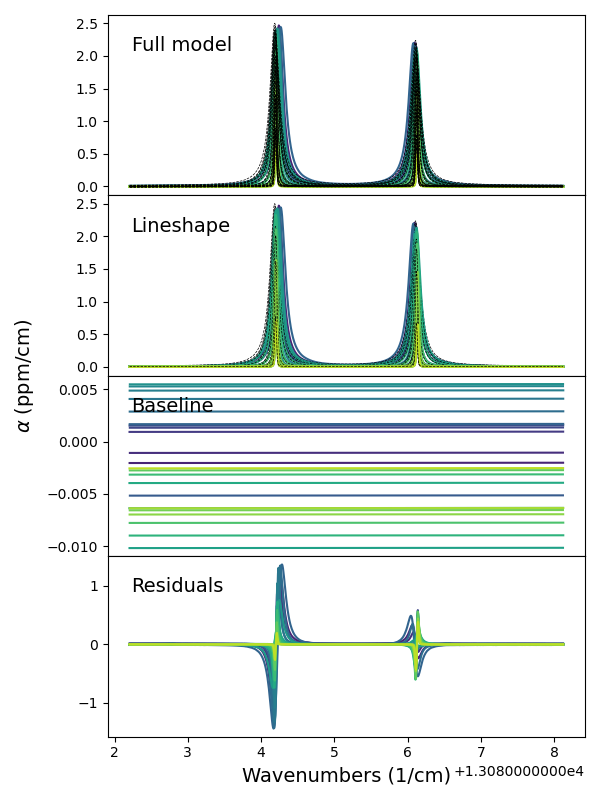

In [19]:
#Predictions after training
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(x)))

fig, ax = plt.subplots(4, sharex=True, sharey=False, figsize=(6, 8))

for i in range(len(x)):
    mean, var = gpr.predict_f(x[i])
    mean = noise_scale * mean[:, 0].numpy()
    var = (noise_scale**2) * var[:, 0].numpy()
    line = noise_scale * gpr.mean_function(x[i]).numpy().flatten()
    ax[0].errorbar(x[i][:, 0], mean, yerr=np.sqrt(var), color=colors[i])
    ax[0].plot(x[i][:, 0], y[i], 'k--', linewidth=0.5, zorder=3)
    ax[1].plot(x[i][:, 0], line, color=colors[i])
    ax[1].plot(x[i][:, 0], y[i] - (mean - line), 'k--', linewidth=0.5)
    ax[2].plot(x[i][:, 0], mean - line, color=colors[i])
    #ax[2].plot(x[i][:, 0], y[i] - line, 'k--')
    ax[3].plot(x[i][:, 0], mean - y[i], color=colors[i])

ax[1].set_ylabel(r'$\alpha$ (ppm/cm)', fontsize=14)
ax[1].yaxis.set_label_coords(-0.15, 0.0)
ax[-1].set_xlabel(r'Wavenumbers (1/cm)', fontsize=14)
ax[0].annotate('Full model', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[1].annotate('Lineshape', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[2].annotate('Baseline', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)
ax[3].annotate('Residuals', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.show()

<IPython.core.display.Javascript object>


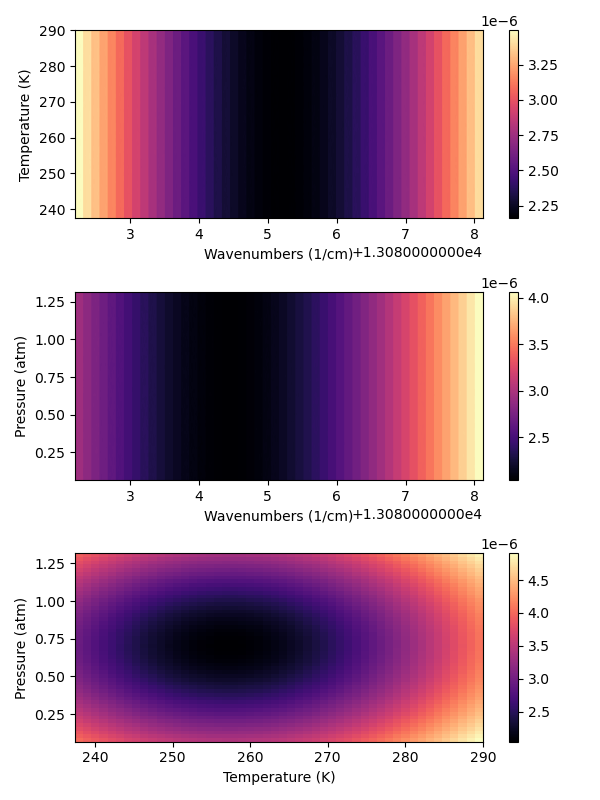

In [20]:
#Look at uncertainty as a function of wavenumber, temperature, pressure
x_vals = np.linspace(np.min(test_x[:, 0]), np.max(test_x[:, 0]), 500)
t_vals = np.linspace(np.min(test_x[:, 1]), np.max(test_x[:, 1]), 50)
p_vals = np.linspace(np.min(test_x[:, 2]), np.max(test_x[:, 2]), 50)

xt_grid = np.vstack([a.flatten() for a in np.meshgrid(x_vals, t_vals)]).T
xt_grid = np.hstack([xt_grid, np.average(p_vals)*np.ones((xt_grid.shape[0], 1))])
xp_grid = np.vstack([a.flatten() for a in np.meshgrid(x_vals, p_vals)]).T
xp_grid = np.vstack([xp_grid[:, 0], np.average(t_vals)*np.ones(xp_grid.shape[0]), xp_grid[:, 1]]).T
tp_grid = np.vstack([a.flatten() for a in np.meshgrid(t_vals, p_vals)]).T
tp_grid = np.hstack([np.average(x_vals)*np.ones((tp_grid.shape[0], 1)), tp_grid])

#Use likelihood for first dataset
xt_grid = np.hstack([xt_grid, np.zeros((xt_grid.shape[0], 1))])
xp_grid = np.hstack([xp_grid, np.zeros((xp_grid.shape[0], 1))])
tp_grid = np.hstack([tp_grid, np.zeros((tp_grid.shape[0], 1))])

fig, ax = plt.subplots(3, figsize=(6, 8))

ax_labels = [('Wavenumbers (1/cm)', 'Temperature (K)'),
             ('Wavenumbers (1/cm)', 'Pressure (atm)'),
             ('Temperature (K)', 'Pressure (atm)')]

shapes = [(500, 50), (500, 50), (50, 50)]

extents = [(xt_grid[0, 0], xt_grid[-1, 0], xt_grid[0, 1], xt_grid[-1, 1]),
           (xp_grid[0, 0], xp_grid[-1, 0], xp_grid[0, 2], xp_grid[-1, 2]),
           (tp_grid[0, 1], tp_grid[-1, 1], tp_grid[0, 2], tp_grid[-1, 2])]

for i, grid in enumerate([xt_grid, xp_grid, tp_grid]):
    mean, var = gpr.predict_f(grid)
    std = noise_scale * np.sqrt(var[:, 0])
    std = np.reshape(std, shapes[i])
    im = ax[i].imshow(std.T, cmap='magma', aspect='auto', origin='lower', extent=extents[i])
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlabel(ax_labels[i][0])
    ax[i].set_ylabel(ax_labels[i][1])
    
fig.tight_layout()
plt.show()